In [1]:
# Install necessary libraries
!pip install transformers torch
!pip install torch
!pip install pandas matplotlib tqdm

# Import required libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns




  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [6]:
df = pd.read_csv('final_data.csv')

# Load XLM-RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")

# Tokenize input texts
tokenized_texts = tokenizer(list(df['Tweet']), padding=True, truncation=True, return_tensors="pt")

# Convert string labels to numerical labels
label_map = {label: index for index, label in enumerate(df['party'].unique())}
df['label'] = df['party'].map(label_map)

# Prepare labels
labels = torch.tensor(df['label'])

# Create TensorDataset
dataset = TensorDataset(tokenized_texts['input_ids'], tokenized_texts['attention_mask'], labels)

# Define batch size
batch_size = 8

# Create DataLoader
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

# Splitting the dataset into train and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [8]:
validation_tokenized_texts = tokenizer(list(validation_df['Tweet']), padding=True, truncation=True, return_tensors="pt")
validation_labels = torch.tensor(validation_df['label'].tolist())  # Convert Series to list
validation_dataset = TensorDataset(validation_tokenized_texts['input_ids'], validation_tokenized_texts['attention_mask'], validation_labels)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

# Load pre-trained XLM-RoBERTa model for sequence classification
# Load pre-trained XLM-RoBERTa model for sequence classification from TensorFlow weights
model = AutoModelForSequenceClassification.from_pretrained("jplu/tf-xlm-roberta-base", num_labels=len(df['party'].unique()), from_tf=True)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training parameters
epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Get the device
model.to(device)  # Move the model to the device

# Lists to store training loss and accuracy
train_loss_values = []
train_accuracy_values = []

tf_model.h5:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing XLMRobertaForSequenceClassification.

All the weights of XLMRobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use XLMRobertaForSequenceClassification for predictions without further training.


Epoch 1/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 1/4, Loss: 0.1916, Accuracy: 0.9217
Epoch 2/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 2/4, Loss: 0.1372, Accuracy: 0.9415
Epoch 3/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 3/4, Loss: 0.2240, Accuracy: 0.9142
Epoch 4/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 4/4, Loss: 0.1521, Accuracy: 0.9346


Validation:   0%|          | 0/77 [00:00<?, ?it/s]

Validation Accuracy: 0.9360

XLM-RoBERTa Classifier Metrics:
Recall: 0.9360
F1 Score: 0.9342
Accuracy: 0.9360


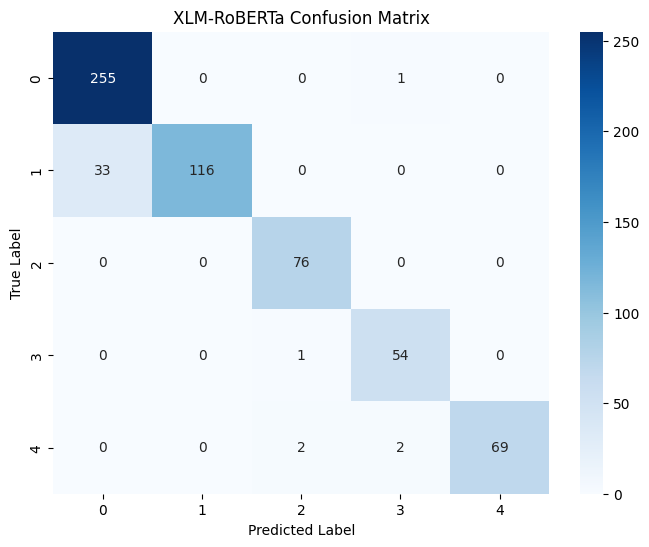

In [10]:
# Training loop
epochs = 4
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training step
    for batch in tqdm(dataloader, desc="Iteration"):
        batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        # Compute training loss
        epoch_loss += loss.item()

        # Compute training accuracy
        _, predicted_labels = torch.max(logits, 1)
        correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_predictions += batch[2].size(0)

    # Calculate average epoch loss and accuracy
    avg_epoch_loss = epoch_loss / len(dataloader)
    train_loss_values.append(avg_epoch_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracy_values.append(train_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}')

# Validation
model.eval()
correct_val_predictions = 0
total_val_predictions = 0
predicted_labels_list = []

for batch in tqdm(validation_dataloader, desc="Validation"):
    batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
    with torch.no_grad():
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        outputs = model(**inputs)
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, 1)
        correct_val_predictions += (predicted_labels == batch[2]).sum().item()
        total_val_predictions += batch[2].size(0)
        predicted_labels_list.extend(predicted_labels.cpu().numpy().tolist())

# Calculate validation accuracy
val_accuracy = correct_val_predictions / total_val_predictions

print(f'Validation Accuracy: {val_accuracy:.4f}')

# Calculate metrics for XLM-RoBERTa
xlm_recall = recall_score(validation_df['label'], predicted_labels_list, average='weighted', zero_division=1)
xlm_f1 = f1_score(validation_df['label'], predicted_labels_list, average='weighted', zero_division=1)
xlm_accuracy = accuracy_score(validation_df['label'], predicted_labels_list)

print("\nXLM-RoBERTa Classifier Metrics:")
print(f"Recall: {xlm_recall:.4f}")
print(f"F1 Score: {xlm_f1:.4f}")
print(f"Accuracy: {xlm_accuracy:.4f}")

# Create confusion matrix
confusion_matrix_xlm = confusion_matrix(validation_df['label'], predicted_labels_list)

# Plot heat map for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_xlm, annot=True, fmt="d", cmap="Blues")
plt.title("XLM-RoBERTa Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

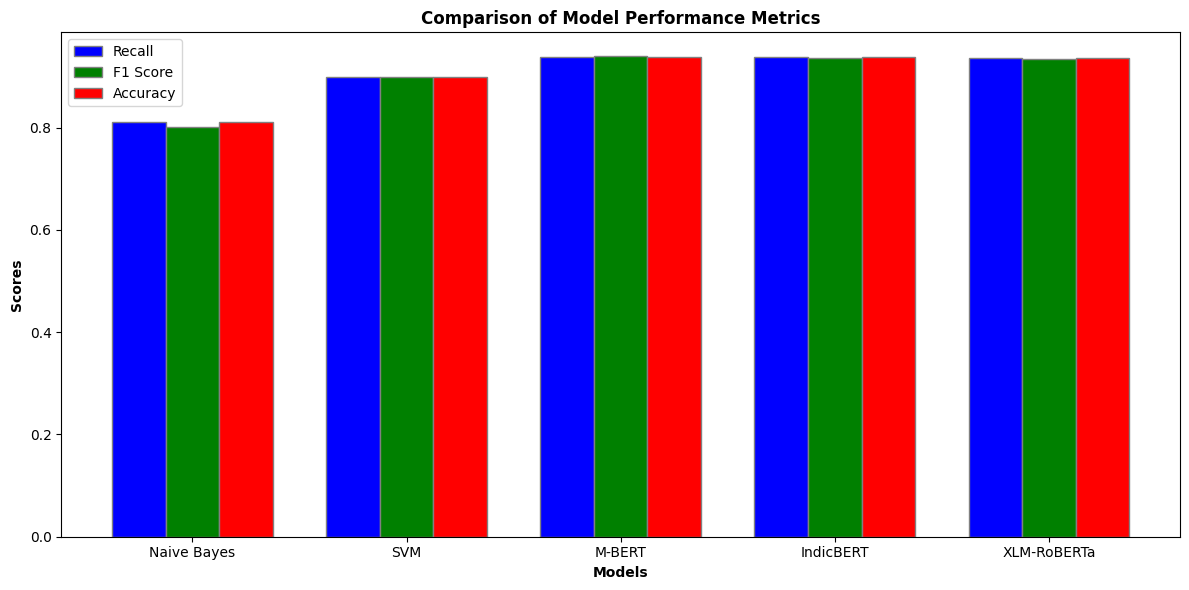

In [11]:
import matplotlib.pyplot as plt

# Define model names and corresponding metrics
models = ['Naive Bayes', 'SVM', 'M-BERT', 'IndicBERT', 'XLM-RoBERTa']
recall_scores = [0.8112, 0.8982, 0.9392, 0.9376, 0.9360]
f1_scores = [0.8023, 0.8990, 0.9395, 0.9362, 0.9342]
accuracy_scores = [0.8112, 0.8982, 0.9392, 0.9376, 0.9360]

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = range(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars
plt.figure(figsize=(12, 6))
plt.bar(r1, recall_scores, color='b', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r2, f1_scores, color='g', width=bar_width, edgecolor='grey', label='F1 Score')
plt.bar(r3, accuracy_scores, color='r', width=bar_width, edgecolor='grey', label='Accuracy')

# Adding labels and title
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.title('Comparison of Model Performance Metrics', fontweight='bold')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
